# Example of phenotypic clustering
This notebook exemplifies some steps involved in working with annotations
from IDR.
It will build parts of Figure 1 of the paper from Rohn et al.
'Comparative RNAi screening identifies a conserved core metazoan
actinome by phenotype,'
see http://dx.doi.org/10.1083/jcb.201103168.
Link to screen on IDR [idr0008-rohn-actinome/screenB](https://idr.openmicroscopy.org/webclient/?show=screen-206)

# Figure 1

![Figure1](./includes/figure1_rohn_phenotype_clustering.png)

### Dependencies
 * [Matplotlib](https://matplotlib.org/)
 * [NumPy](https://www.numpy.org/)
 * [Pandas](https://pandas.pydata.org/)
 * [SciPy](https://www.scipy.org/)
 * [Seaborn](https://seaborn.pydata.org/)

In [7]:
from IPython import get_ipython
import random
import re
import omero

import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hchy

from seaborn import clustermap
from pandas import DataFrame
from idr import connection
import warnings

get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['image.cmap'] = 'gray'

### Common variables

In [8]:
screenId = 206

### Method definitions

In [9]:
def buildComposite(st, n, m, smpl=None):
    """
    nxm shots from st in a grid, as an image
    """
    nr = st.shape[0]
    nc = st.shape[1]
    if smpl is None:
        smpl = st.shape[2] // (n * m)
    res = np.zeros((nr * n, nc * m))
    for i in range(n):
        for j in range(m):
            try:
                res[i * nr: i * nr + nr,
                    j * nc: j * nc + nc] = st[:, :, (i * m + j)*smpl]
            except Exception:
                break
    return res

In [10]:
def getRohnTile(imid, x, y, w, h, conn, chan=0):
    """
    fetches one tile from one image
    """
    im = conn.getObject("Image", imid)
    pix = im.getPrimaryPixels()

    tile = (x, y, w, h)
    plane = pix.getTile(theZ=0, theT=0, theC=chan, tile=tile)

    return plane

In [11]:
def getBulkAnnotationAsDf(screenID, conn):
    ofId = None
    sc = conn.getObject('Screen', screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName() == 'bulk_annotations'):
                if (ann.getFile().getSize() > 1476250900):
                    print("that's a big file...")
                    return None
                ofId = ann.getFile().getId()
                break

    if ofId is None:
        return None

    original_file = omero.model.OriginalFileI(ofId, False)

    table = conn.c.sf.sharedResources().openTable(original_file)
    count = 0
    try:
        rowCount = table.getNumberOfRows()

        column_names = []
        pattern = re.compile(r"Phenotype \d+$")
        for col in table.getHeaders():
            column_names.append(col.name)
            if pattern.match(col.name) is not None:
                count = count + 1

        black_list = []
        column_indices = []
        for column_name in column_names:
            if column_name in black_list:
                continue
            column_indices.append(column_names.index(column_name))

        table_data = table.slice(column_indices, None)
    finally:
        table.close()

    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn = DataFrame(data)
    dfAnn.columns = column_names
    return dfAnn, count

### Connect to IDR

In [12]:
conn = connection('idr.openmicroscopy.org')

Connected to IDR ...


### Download the annotation file for the whole screen

In [13]:
dfRhonAnn, phenotype_count = getBulkAnnotationAsDf(screenId, conn)

### Phenotype clustering

#### A. Transforming phenotypes into one-hot booleans

In [14]:
BoolCols = []
PhenLab = []
total = phenotype_count + 1
for iphen in range(1, total):
    col = 'Phenotype ' + str(iphen)
    dfRhonAnn['Bool' + col] = ~ (dfRhonAnn[col] == '')
    BoolCols.append('Bool' + col)
    PhenLab.append(dfRhonAnn[col].unique()[1])

#### B. Performing the hierarchical linkage on the gene with a phenotype

In [15]:
# count a gene as having a phenotype
# if at least one well annotated with
# it has a phenotype
value = dfRhonAnn['Has Phenotype'] == 'yes'
phenMap = dfRhonAnn[value].groupby('Gene Symbol')[BoolCols].sum() > 0
phenMap = phenMap[phenMap.sum(axis=1) > 0]
phenMap.columns = PhenLab
phenMap.replace([False, True], [0, 1], inplace=True)
Z = hchy.linkage(phenMap, 'ward')
Zt = hchy.linkage(phenMap.transpose(), 'ward')

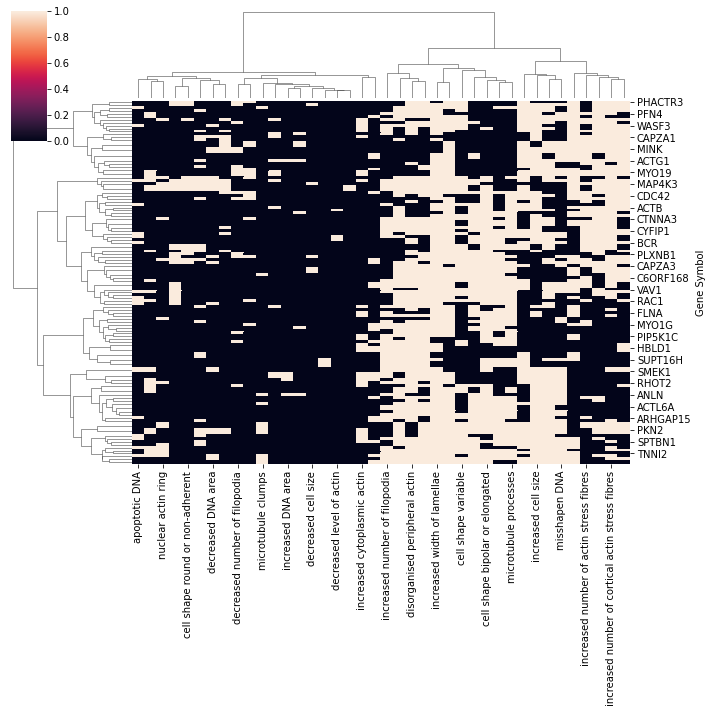

In [16]:
warnings.filterwarnings('ignore')

cg = clustermap(phenMap, row_linkage=Z, col_linkage=Zt, figsize=(10, 10))
for item in cg.ax_heatmap.get_xticklabels():
    item.set_rotation(90)
for item in cg.ax_heatmap.get_yticklabels():
    item.set_rotation(0)

### Building a gallery of images for visualization

A. Gallery of tiles for several phenotypes

In [ ]:
# hard coded, but corresponds to tile size used for CHARM features computation
X = [0, 580, 116, 348, 232, 464]
Y = [0, 348,  87, 174, 261]
ni = 15
w = 116
h = 86

# some phenotype
phs = range(20, phenotype_count - 10)

tiles = np.zeros((h, w, len(phs) * ni))
for kk, ph in enumerate(phs):
    ws = dfRhonAnn[dfRhonAnn['Phenotype ' + str(ph)] != ''].Well
    for ii in range(ni):
        we = random.choice(ws.values)
        we = conn.getObject('Well', we)
        i = we.getImage()
        x = random.choice(X)
        y = random.choice(Y)
        tiles[:, :, ii+kk*ni] = getRohnTile(i.getId(), x, y, w, h, conn,
                                            chan=1)

plt.figure(figsize=(15, 15))
imc = buildComposite(tiles, len(phs), ni)
plt.grid(False)
plt.imshow(imc)

### Disconnect when done loading data

In [ ]:
conn.close()

### License
Copyright (C) 2016-2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.